In [1]:
import intake
import cmocean
import numpy as np
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

import easygems.healpix as egh
import pandas as pd
import matplotlib

In [2]:
from wblib.figures.hifs import HifsForecasts
from wblib.figures.briefing_info import INTERNAL_FIGURE_SIZE
from wblib.figures.briefing_info import ORCESTRA_DOMAIN

/Applications/miniconda3/envs/wblib/lib/python3.12/site-packages/goes2go/data.py:665: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),
/Applications/miniconda3/envs/wblib/lib/python3.12/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1h")),


In [3]:
def get_analysis_data(valid_time):
    valid_time = _check_datetime(valid_time, 15)
    ref_time = "12"
    cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
    hifs = cat.HIFS(refdate=valid_time.strftime("%Y-%m-%d"), 
                    reftime=ref_time)
    ds = hifs.to_dask().pipe(egh.attach_coords)
    ds = ds.sel(time=valid_time)    
    return ds 


def get_forecast_data(valid_time, lead_hours):
    valid_time = _check_datetime(valid_time, refhour=15)
    lead = pd.Timedelta(hours=lead_hours)
    issued_time = valid_time - lead
    issued_time = _check_datetime(issued_time, refhour=0)
    cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
    hifs = cat.HIFS(datetime=issued_time.strftime("%Y-%m-%d %H"))
    ds = hifs.to_dask().pipe(egh.attach_coords)
    ds = ds.sel(time=valid_time)
    return ds

def _check_datetime(datetime, refhour=15):
    new_datetime = pd.Timestamp(datetime)
    if new_datetime.hour != refhour:
        raise NotImplementedError(f"Ony time=15 is implemented.") 
    return new_datetime

def get_variable(ds, variable):
    if variable == "wind_speed":
        u10m = ds["10u"]
        v10m = ds["10v"]
        windspeed_10m = np.sqrt(u10m**2 + v10m**2)
        windspeed_10m = windspeed_10m.assign_attrs(
            {"long_name": "Wind speed", "units": "m s^-1"}
        )
        windspeed_10m.name = "wind_speed"
        return windspeed_10m
    return ds[variable]

In [4]:
def format_axes(ax, crs=ccrs.PlateCarree()):
    lon_min, lon_max, lat_min, lat_max = ORCESTRA_DOMAIN
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.coastlines(lw=1.0, color="k")
    ax.set_xticks(np.round(np.linspace(-70, 10, 9), 0), crs=crs)
    ax.set_yticks(np.round(np.linspace(-20, 20, 5), 0), crs=crs)
    ax.set_ylabel("Latitude / \N{DEGREE SIGN}N")
    ax.set_xlabel("Longitude / \N{DEGREE SIGN}E")
    ax.set_xlim([lon_min, lon_max])
    ax.set_ylim([lat_min, lat_max])

In [5]:
# Define script parameters
valid_time = "2024-09-12 15"
variable = "wind_speed"
figname = f"ECMWF_operational_verf_{variable}_{valid_time}.png"

In [6]:
VARIABLE_LEVES = {
    "wind_speed": 3,
    "tcwv": 48
}
VARIABLE_LEADS = {
    "wind_speed": 6,
    "tcwv": 6    
}

In [7]:
n_lead = VARIABLE_LEADS[variable]
lead_times = [15 + 24*i for i in range(n_lead)]
lead_times.reverse()
alphas = np.linspace(0.5, 1, n_lead)
cmap = matplotlib.colormaps['viridis_r']
colors = cmap(np.linspace(0, 0.5, n_lead))
legend_elements = [
    plt.Line2D([0], [0], color=color, label=f'Lead {lead} hours')
    for color, lead in zip(colors, lead_times)
    ]
legend_elements.append(plt.Line2D([0], [0], color="k", label=f'Lead 3 hours'))

In [8]:
forecasts = []
for lead_time in lead_times:
    ds_forecast = get_forecast_data(valid_time, lead_time)
    forecast = get_variable(ds_forecast, variable)
    forecasts.append(forecast)
ds_analysis = get_analysis_data(valid_time)
analysis = get_variable(ds_analysis, variable)

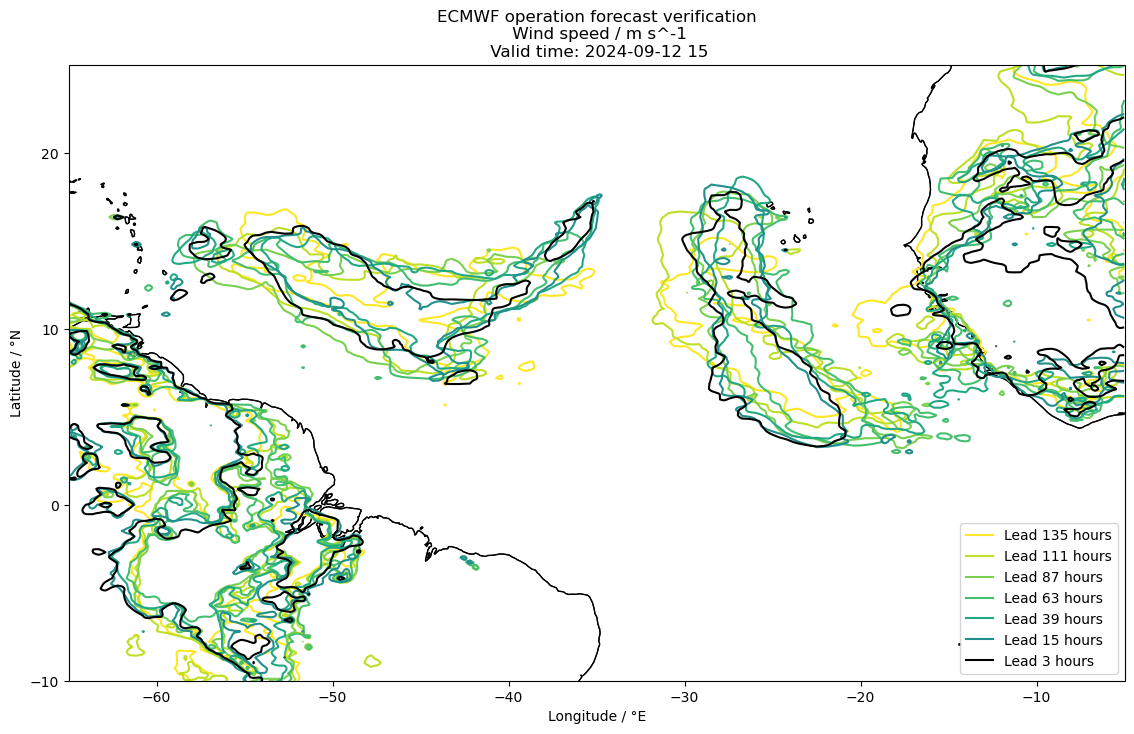

In [9]:
fig, ax = plt.subplots(figsize=INTERNAL_FIGURE_SIZE, 
                       subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([-65, -5, -10, 25])
ax.coastlines(lw=0.8)
for i, forecast in enumerate(forecasts):
    cs = egh.healpix_contour(
        forecast,
        method="linear",
        colors=[colors[i]],
        #alpha=alphas[i],
        levels=[VARIABLE_LEVES[variable]],
    )
egh.healpix_contour(
    analysis,
    method="linear",
    colors=["k"],
    levels=[VARIABLE_LEVES[variable]],
)
format_axes(ax)
ax.legend(handles=legend_elements, loc='lower right')
ax.set_title("ECMWF operation forecast verification"
             f"\n {analysis.long_name} / {analysis.units}"
             f"\n Valid time: {valid_time}")
plt.savefig(figname)